# Sentinel-2 data in Python

## Accessing data via STAC API

Libraries needed for this exercise are imported below:

In [2]:
import geogif # render gifs from raster images
import geopandas as gpd # handle geospatial data frames
from IPython.display import Image # visualize URLs
import pandas as pd # data wrangling
import pystac_client # connecting to the STAC API
from rasterio.enums import Resampling # perform resampling operations
import rioxarray # handle spatio-temporal arrays
import shapely # create vector objects
import stackstac # build an on-demand STAC data cube

### Querying data with `pystac-client`

[STAC](https://stacspec.org/en) stands for SpatioTemporal Asset Catalog and it is "a common language to describe geospatial information, so it can more easily be worked with, indexed, and discovered". 

[`pystac-client`](https://pystac-client.readthedocs.io/en/stable/quickstart.html#python) allows the querying of a STAC API using Python.

There are several APIs available to query data, you can browse them all in the [STAC catalog index](https://stacindex.org/catalogs). Some of these APIs will require authentication to access the data. We will use the [Earth Search](https://www.element84.com/earth-search/) catalog for this notebook, which allows querying data on Amazon Web Services (AWS). The data we will fetch does not require authentication.

In [3]:
# STAC API URL 
api_url = 'https://earth-search.aws.element84.com/v1'

To start fetching data, we will open the client. We can see the collections available for this API:

In [4]:
client = pystac_client.Client.open(api_url)
for collection in client.get_collections():
    print(collection)

<CollectionClient id=cop-dem-glo-30>
<CollectionClient id=naip>
<CollectionClient id=sentinel-2-l2a>
<CollectionClient id=sentinel-2-l1c>
<CollectionClient id=landsat-c2-l2>
<CollectionClient id=cop-dem-glo-90>
<CollectionClient id=sentinel-1-grd>


Let's focus on Sentinel-2 data level 2a. [Here are the different levels that Sentinel-2 has](https://sentinels.copernicus.eu/web/sentinel/user-guides/sentinel-2-msi/processing-levels). Level 2a provides atmospherically corrected data representing surface reflectance.

In [5]:
# collection ID
collection = 'sentinel-2-l2a'

Let's define now the spatial and temporal extent for our query. We will query all scenes intersecting the point coordinates and the time range given. 

In [6]:
# coordinates
lon = 16.9
lat = 52.4
# date range
datetime = '2022-05-01/2022-10-01'
point = shapely.Point(lon, lat)

And we pass these arguments to our search:

In [7]:
search = client.search(
    collections=[collection],
    intersects=point,
    datetime=datetime,
    # query=["eo:cloud_cover<10"],
)

In [8]:
items = search.item_collection()
len(items)

61

We can view our query as a Geopandas data frame for easier readability:

In [9]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")
df

geometry  \
0   POLYGON ((16.49848 53.24020, 17.39525 53.22555...   
1   POLYGON ((16.49848 53.24020, 18.14175 53.20819...   
2   POLYGON ((16.49848 53.24020, 17.40513 53.22535...   
3   POLYGON ((16.49848 53.24020, 18.14175 53.20819...   
4   POLYGON ((16.49848 53.24020, 17.39525 53.22555...   
..                                                ...   
56  POLYGON ((16.49848 53.24020, 17.40334 53.22538...   
57  POLYGON ((16.49848 53.24020, 18.14175 53.20819...   
58  POLYGON ((16.49848 53.24020, 17.41321 53.22518...   
59  POLYGON ((16.49848 53.24020, 18.14175 53.20819...   
60  POLYGON ((16.49848 53.24020, 17.41321 53.22518...   

                     created     platform constellation instruments  \
0   2022-11-06T13:16:26.947Z  sentinel-2b    sentinel-2       [msi]   
1   2022-11-06T13:11:18.176Z  sentinel-2b    sentinel-2       [msi]   
2   2022-11-06T13:11:20.946Z  sentinel-2a    sentinel-2       [msi]   
3   2022-11-06T13:16:12.947Z  sentinel-2a    sentinel-2       [msi]   
4   2022-11-06T12:53:03.225Z  sentinel-2b    sentinel-2       [msi]   
..                       ...          ...           ...         ...   
56  2022-11-06T12:53:10.300Z  sentinel-2b    sentinel-2       [msi]   
57  2022-11-05T21:23:34.496Z  sentinel-2b    sentinel-2       [msi]   
58  2022-11-06T12:53:56.047Z  sentinel-2a    sentinel-2       [msi]   
59  2022-11-06T12:53:17.748Z  sentinel-2a    sentinel-2       [msi]   
60  2022-11-06T13:15:55.333Z  sentinel-2b    sentinel-2       [msi]   

    eo:cloud_cover  proj:epsg  mgrs:utm_zone mgrs:latitude_band  \
0        58.454198      32633             33                  U   
1        98.291922      32633             33                  U   
2        87.133706      32633             33                  U   
3        44.240642      32633             33                  U   
4        43.062508      32633             33                  U   
..             ...        ...            ...                ...   
56       99.998361      32633             33                  U   
57       27.876577      32633             33                  U   
58       46.102655      32633             33                  U   
59       37.965998      32633             33                  U   
60       37.874487      32633             33                  U   

   mgrs:grid_square  ...                                      s2:granule_id  \
0                XU  ...  S2B_OPER_MSI_L2A_TL_2BPS_20220930T130034_A0290...   
1                XU  ...  S2B_OPER_MSI_L2A_TL_2BPS_20220927T124321_A0290...   
2                XU  ...  S2A_OPER_MSI_L2A_TL_ATOS_20220925T162525_A0379...   
3                XU  ...  S2A_OPER_MSI_L2A_TL_ATOS_20220922T174559_A0378...   
4                XU  ...  S2B_OPER_MSI_L2A_TL_2BPS_20220921T213031_A0289...   
..              ...  ...                                                ...   
56               XU  ...  S2B_OPER_MSI_L2A_TL_2BPS_20220513T151459_A0270...   
57               XU  ...  S2B_OPER_MSI_L2A_TL_2BPS_20220510T122841_A0270...   
58               XU  ...  S2A_OPER_MSI_L2A_TL_ATOS_20220508T173819_A0359...   
59               XU  ...  S2A_OPER_MSI_L2A_TL_ATOS_20220505T140120_A0358...   
60               XU  ...  S2B_OPER_MSI_L2A_TL_2BPS_20220503T131739_A0269...   

    s2:reflectance_conversion_factor                     datetime  \
0                           0.995562  2022-09-30T10:15:59.525000Z   
1                           0.993868  2022-09-27T10:06:03.949000Z   
2                           0.992756  2022-09-25T10:16:07.244000Z   
3                           0.991098  2022-09-22T10:06:10.734000Z   
4                           0.990012  2022-09-20T10:16:01.523000Z   
..                               ...                          ...   
56                          0.981369  2022-05-13T10:15:58.447000Z   
57                          0.982781  2022-05-10T10:06:01.099000Z   
58                          0.983747  2022-05-08T10:16:04.335000Z   
59                          0.985238  2022-05-05T10:06:08.44000

This proves useful for example when we want to visualize the cloud cover of our whole collection:

<Axes: title={'center': 'eo:cloud-cover'}, xlabel='datetime'>

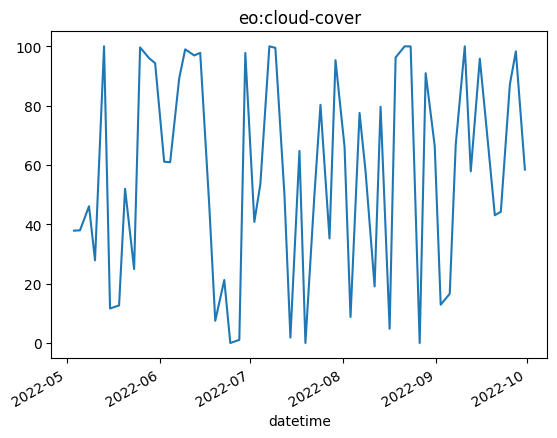

In [10]:
df["datetime"] = pd.to_datetime(df["datetime"])

ts = df.set_index("datetime").sort_index()["eo:cloud_cover"]
ts.plot(title="eo:cloud-cover")

Let's explore the properties of one item. But first let's look for an item index with low cloud cover and low nodata.

In [51]:
df_filt = df.loc[(df['eo:cloud_cover'] <= 2) & (df['s2:nodata_pixel_percentage'] <= 10)]
df_filt

geometry  \
29  POLYGON ((16.49848 53.24020, 18.14175 53.20819...   
31  POLYGON ((16.49848 53.24020, 18.14175 53.20819...   
39  POLYGON ((16.49848 53.24020, 18.14175 53.20819...   

                     created     platform constellation instruments  \
29  2022-11-06T13:14:37.621Z  sentinel-2b    sentinel-2       [msi]   
31  2022-11-06T12:54:05.312Z  sentinel-2a    sentinel-2       [msi]   
39  2022-11-06T12:52:50.337Z  sentinel-2a    sentinel-2       [msi]   

    eo:cloud_cover  proj:epsg  mgrs:utm_zone mgrs:latitude_band  \
29        0.005511      32633             33                  U   
31        1.825375      32633             33                  U   
39        0.002495      32633             33                  U   

   mgrs:grid_square  ...                                      s2:granule_id  \
29               XU  ...  S2B_OPER_MSI_L2A_TL_2BPS_20220719T113943_A0280...   
31               XU  ...  S2A_OPER_MSI_L2A_TL_ATOS_20220714T175057_A0368...   
39               XU  ...  S2A_OPER_MSI_L2A_TL_ATOS_20220624T143914_A0365...   

    s2:reflectance_conversion_factor                         datetime  \
29                          0.967885 2022-07-19 10:06:08.645000+00:00   
31                          0.967507 2022-07-14 10:06:16.331000+00:00   
39                          0.968339 2022-06-24 10:06:16.177000+00:00   

    s2:sequence                                earthsearch:s3_path  \
29            0  s3://sentinel-cogs/sentinel-s2-l2a-cogs/33/U/X...   
31            0  s3://sentinel-cogs/sentinel-s2-l2a-cogs/33/U/X...   
39            0  s3://sentinel-cogs/sentinel-s2-l2a-cogs/33/U/X...   

                               earthsearch:payload_id  \
29  roda-sentinel2/workflow-sentinel2-to-stac/4f39...   
31  roda-sentinel2/workflow-sentinel2-to-stac/1cea...   
39  roda-sentinel2/workflow-sentinel2-to-stac/9b8a...   

    earthsearch:boa_offset_applied             processing:software  \
29                            True  {'sentinel2-to-stac': '0.1.0'}   
31                            True  {'sentinel2-to-stac': '0.1.0'}   
39                            True  {'sentinel2-to-stac': '0.1.0'}   

                     updated  s2:mgrs_tile  
29  2022-11-06T13:14:37.621Z           NaN  
31  2022-11-06T12:54:05.312Z           NaN  
39  2022-11-06T12:52:50.337Z           NaN  

[3 rows x 43 columns]

In [52]:
item = items[df_filt.index[0]]
item.geometry

{'type': 'Polygon',
 'coordinates': [[[16.498475093400046, 53.240199174677954],
   [18.141754296879448, 53.20819279121764],
   [18.071664488869853, 52.22257539160585],
   [16.464995307918354, 52.25346561204129],
   [16.498475093400046, 53.240199174677954]]]}

In [38]:
item.datetime

datetime.datetime(2022, 7, 19, 10, 6, 8, 645000, tzinfo=tzutc())

In [39]:
item.properties

{'created': '2022-11-06T13:14:37.621Z',
 'platform': 'sentinel-2b',
 'constellation': 'sentinel-2',
 'instruments': ['msi'],
 'eo:cloud_cover': 0.005511,
 'proj:epsg': 32633,
 'mgrs:utm_zone': 33,
 'mgrs:latitude_band': 'U',
 'mgrs:grid_square': 'XU',
 'grid:code': 'MGRS-33UXU',
 'view:sun_azimuth': 157.993614061013,
 'view:sun_elevation': 56.588942214785,
 's2:degraded_msi_data_percentage': 0,
 's2:nodata_pixel_percentage': 3e-06,
 's2:saturated_defective_pixel_percentage': 0,
 's2:dark_features_percentage': 0.004429,
 's2:cloud_shadow_percentage': 0,
 's2:vegetation_percentage': 64.467937,
 's2:not_vegetated_percentage': 34.062394,
 's2:water_percentage': 1.263951,
 's2:unclassified_percentage': 0.195772,
 's2:medium_proba_clouds_percentage': 7e-05,
 's2:high_proba_clouds_percentage': 3e-06,
 's2:thin_cirrus_percentage': 0.005438,
 's2:snow_ice_percentage': 0,
 's2:product_type': 'S2MSI2A',
 's2:processing_baseline': '04.00',
 's2:product_uri': 'S2B_MSIL2A_20220719T095559_N0400_R122_

We can also take a look at the assets for the item. That is which bands are available. 

In [40]:
item.assets.keys()

dict_keys(['aot', 'blue', 'coastal', 'granule_metadata', 'green', 'nir', 'nir08', 'nir09', 'red', 'rededge1', 'rededge2', 'rededge3', 'scl', 'swir16', 'swir22', 'thumbnail', 'tileinfo_metadata', 'visual', 'wvp', 'aot-jp2', 'blue-jp2', 'coastal-jp2', 'green-jp2', 'nir-jp2', 'nir08-jp2', 'nir09-jp2', 'red-jp2', 'rededge1-jp2', 'rededge2-jp2', 'rededge3-jp2', 'scl-jp2', 'swir16-jp2', 'swir22-jp2', 'visual-jp2', 'wvp-jp2'])

And we can also preview how this scene looks like:

In [41]:
thumbnail = item.assets["thumbnail"].href
Image(url = thumbnail)

Let's take a look at one single band:

In [42]:
asset = item.assets["red"]

In [43]:
asset.extra_fields

{'eo:bands': [{'name': 'red',
   'common_name': 'red',
   'description': 'Red (band 4)',
   'center_wavelength': 0.665,
   'full_width_half_max': 0.038}],
 'gsd': 10,
 'proj:shape': [10980, 10980],
 'proj:transform': [10, 0, 600000, 0, -10, 5900040],
 'raster:bands': [{'nodata': 0,
   'data_type': 'uint16',
   'bits_per_sample': 15,
   'spatial_resolution': 10,
   'scale': 0.0001,
   'offset': -0.1}]}

And read it with [`rioxarray`](https://corteva.github.io/rioxarray/stable/).

In [44]:
red = rioxarray.open_rasterio(item.assets["red"].href, decode_coords="all")

We can now plot the data, in this case a subset to speed up the process. That is achieved with the `isel()` function.

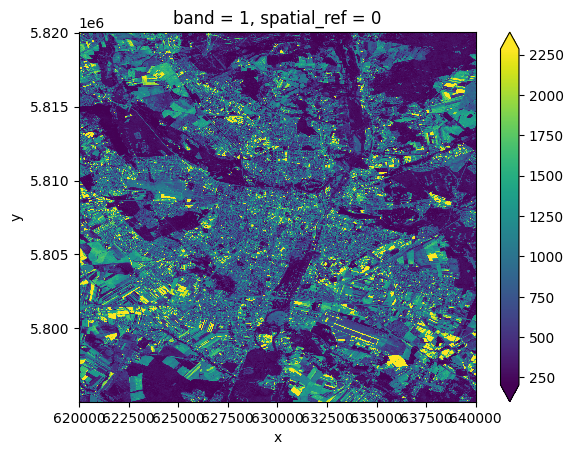

In [45]:
red.isel(x=slice(2000, 4000), y=slice(8000, 10500)).plot(robust=True)

What about an RGB representation?

In [13]:
rgb = rioxarray.open_rasterio(item.assets["visual"].href)

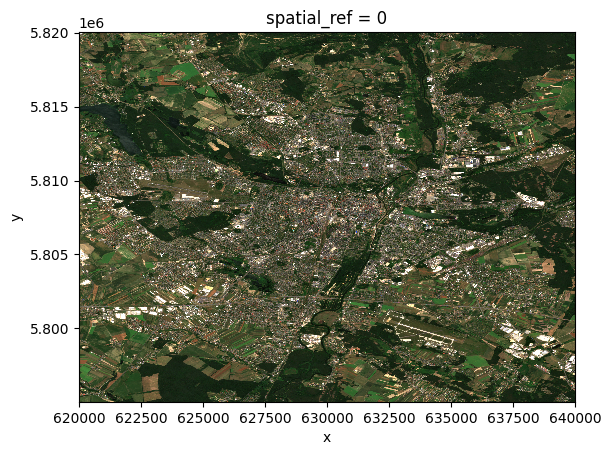

In [14]:
rgb.isel(x=slice(2000, 4000), y=slice(8000, 10500)).plot.imshow()

### Creating a STAC data cube

To work with the STAC items as a data cube we can use the [`stackstac`](https://stackstac.readthedocs.io/en/latest/) package. 

To limit our data cube size we will create it only focused on the Poznan bounding box.

In [34]:
footprint = gpd.read_file("../../data/poznan.geojson")
footprint.total_bounds

array([16.75738404, 52.29364398, 17.16361743, 52.53564773])

In [75]:
cube = stackstac.stack(
    items,
    resolution=100,
    bounds_latlon=footprint.total_bounds,
    resampling=Resampling.bilinear
)
cube

/opt/conda/lib/python3.11/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-c5c8aea234236d3ba4ed1d201464108f' (time: 8,
                                                                band: 32,
                                                                y: 278, x: 285)>
dask.array<fetch_raster_window, shape=(8, 32, 278, 285), dtype=float64, chunksize=(1, 1, 278, 285), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2022-06-19...
    id                                       (time) <U24 'S2B_33UXU_20220619_...
  * band                                     (band) <U12 'aot' ... 'wvp-jp2'
  * x                                        (x) float64 6.191e+05 ... 6.475e+05
  * y                                        (y) float64 5.823e+06 ... 5.795e+06
    s2:generation_time                       (time) <U27 '2022-06-19T11:43:29...
    ...                                       ...
    title                                    (band) <U31 'Aerosol optical thi...
    gsd                                      (band) object None 10 ... None None
    common_name                              (band) object None 'blue' ... None
    center_wavelength                        (band) object None 0.49 ... None
    full_width_half_max                      (band) object None 0.098 ... None
    epsg                                     int64 32633
Attributes:
    spec:        RasterSpec(epsg=32633, bounds=(619100, 5795100, 647600, 5822...
    crs:         epsg:32633
    transform:   | 100.00, 0.00, 619100.00|\n| 0.00,-100.00, 5822900.00|\n| 0...
    resolution:  100

We can further wrangle this cube by selecting only RGB bands and creating monthly composites. We can achieve this with `xarray` resample. This are all the [time range formats](https://docs.xarray.dev/en/latest/generated/xarray.cftime_range.html) supported. 

In [76]:
rgb = cube.sel(band=["red", "green", "blue"])
monthly = rgb.resample(time="MS").median("time", keep_attrs=True)

In [77]:
monthly

<xarray.DataArray 'stackstac-c5c8aea234236d3ba4ed1d201464108f' (time: 3,
                                                                band: 3,
                                                                y: 278, x: 285)>
dask.array<stack, shape=(3, 3, 278, 285), dtype=float64, chunksize=(1, 3, 278, 285), chunktype=numpy.ndarray>
Coordinates: (12/26)
  * band                                     (band) <U12 'red' 'green' 'blue'
  * x                                        (x) float64 6.191e+05 ... 6.475e+05
  * y                                        (y) float64 5.823e+06 ... 5.795e+06
    s2:product_type                          <U7 'S2MSI2A'
    mgrs:grid_square                         <U2 'XU'
    proj:epsg                                int64 32633
    ...                                       ...
    gsd                                      (band) object 10 10 10
    common_name                              (band) object 'red' 'green' 'blue'
    center_wavelength                        (band) object 0.665 0.56 0.49
    full_width_half_max                      (band) object 0.038 0.045 0.098
    epsg                                     int64 32633
  * time                                     (time) datetime64[ns] 2022-06-01...
Attributes:
    spec:        RasterSpec(epsg=32633, bounds=(619100, 5795100, 647600, 5822...
    crs:         epsg:32633
    transform:   | 100.00, 0.00, 619100.00|\n| 0.00,-100.00, 5822900.00|\n| 0...
    resolution:  100

We will use the `compute()` function from [`dask`](https://docs.dask.org/en/stable/) to read our object in-memory. 

In [78]:
monthly = monthly.compute()

This will make plotting tasks faster.

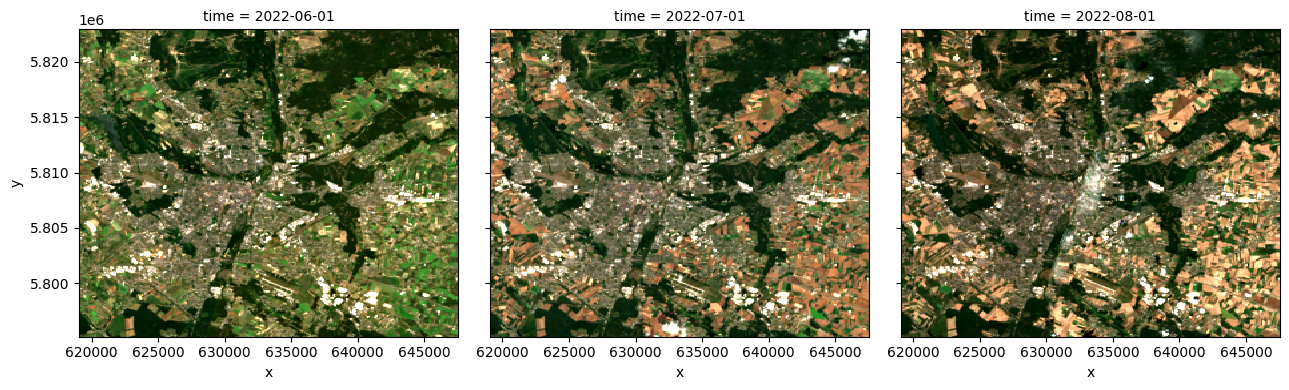

In [79]:
monthly.plot.imshow(
    col="time",
    col_wrap=3,
    rgb="band",
    robust=True,
    size=4,
    add_labels=False,
)

Let's take a look now at a smaller area to visualize crops around Poznan.

In [61]:
crops = gpd.read_file("../../data/crops.geojson")
cube = stackstac.stack(
    items,
    resolution=10,
    bounds_latlon=crops.total_bounds,
    resampling=Resampling.bilinear
)
rgb = cube.sel(band=["red", "green", "blue"])
rgb

/opt/conda/lib/python3.11/site-packages/stackstac/prepare.py:364: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  times = pd.to_datetime(


<xarray.DataArray 'stackstac-58425e06c03cfcb1274e7ff63a0e575e' (time: 8,
                                                                band: 3,
                                                                y: 748, x: 1239)>
dask.array<getitem, shape=(8, 3, 748, 1239), dtype=float64, chunksize=(1, 1, 748, 1024), chunktype=numpy.ndarray>
Coordinates: (12/52)
  * time                                     (time) datetime64[ns] 2022-06-19...
    id                                       (time) <U24 'S2B_33UXU_20220619_...
  * band                                     (band) <U12 'red' 'green' 'blue'
  * x                                        (x) float64 6.328e+05 ... 6.452e+05
  * y                                        (y) float64 5.809e+06 ... 5.801e+06
    s2:generation_time                       (time) <U27 '2022-06-19T11:43:29...
    ...                                       ...
    title                                    (band) <U31 'Red (band 4) - 10m'...
    gsd                                      (band) object 10 10 10
    common_name                              (band) object 'red' 'green' 'blue'
    center_wavelength                        (band) object 0.665 0.56 0.49
    full_width_half_max                      (band) object 0.038 0.045 0.098
    epsg                                     int64 32633
Attributes:
    spec:        RasterSpec(epsg=32633, bounds=(632780, 5801330, 645170, 5808...
    crs:         epsg:32633
    transform:   | 10.00, 0.00, 632780.00|\n| 0.00,-10.00, 5808810.00|\n| 0.0...
    resolution:  10

For a quick view, we can generate a GIF of the Sentinel-2 scenes we have available.

In [62]:
gif_crops = geogif.dgif(rgb).compute()

/opt/conda/lib/python3.11/site-packages/geogif/gif.py:190: RuntimeWarning: invalid value encountered in cast
  u8 = (data * 255).astype("uint8")


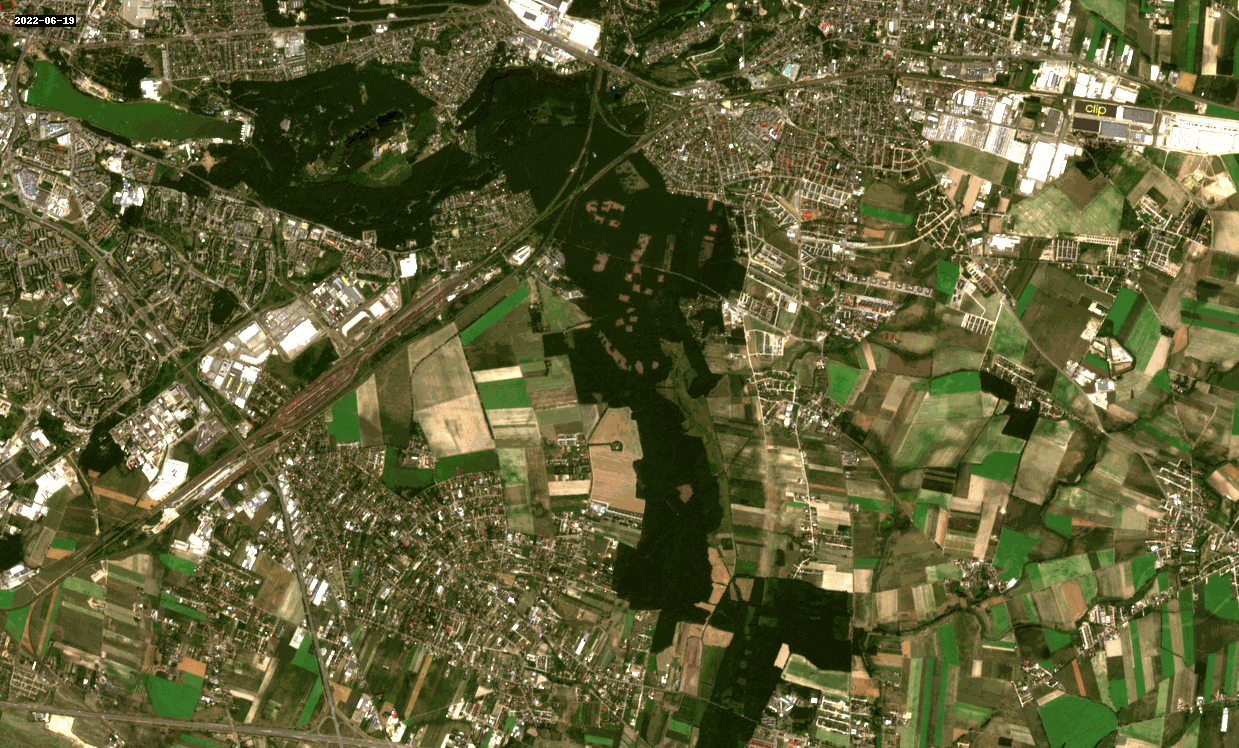

In [63]:
gif_crops

We can work on derived calculation, for example, we can compute the NDVI per scene

In [64]:
nir, red = cube.sel(band="nir"), cube.sel(band="red")
ndvi = (nir - red) / (nir + red)

In [65]:
ndvi

<xarray.DataArray 'stackstac-58425e06c03cfcb1274e7ff63a0e575e' (time: 8,
                                                                y: 748, x: 1239)>
dask.array<truediv, shape=(8, 748, 1239), dtype=float64, chunksize=(1, 748, 1024), chunktype=numpy.ndarray>
Coordinates: (12/47)
  * time                                     (time) datetime64[ns] 2022-06-19...
    id                                       (time) <U24 'S2B_33UXU_20220619_...
  * x                                        (x) float64 6.328e+05 ... 6.452e+05
  * y                                        (y) float64 5.809e+06 ... 5.801e+06
    s2:generation_time                       (time) <U27 '2022-06-19T11:43:29...
    s2:dark_features_percentage              (time) float64 0.002057 ... 0.01486
    ...                                       ...
    s2:processing_baseline                   <U5 '04.00'
    created                                  (time) <U24 '2022-11-06T13:16:38...
    s2:granule_id                            (time) <U62 'S2B_OPER_MSI_L2A_TL...
    raster:bands                             object [{'nodata': 0, 'data_type...
    gsd                                      object 10
    epsg                                     int64 32633

Let's create a composite with the maximum NDVI value for the whole collection over time.

In [66]:
ndvi_comp = ndvi.max("time")

In [67]:
ndvi_comp

<xarray.DataArray 'stackstac-58425e06c03cfcb1274e7ff63a0e575e' (y: 748, x: 1239)>
dask.array<_nanmax_skip-aggregate, shape=(748, 1239), dtype=float64, chunksize=(748, 1024), chunktype=numpy.ndarray>
Coordinates: (12/20)
  * x                                        (x) float64 6.328e+05 ... 6.452e+05
  * y                                        (y) float64 5.809e+06 ... 5.801e+06
    s2:product_type                          <U7 'S2MSI2A'
    mgrs:grid_square                         <U2 'XU'
    proj:epsg                                int64 32633
    s2:snow_ice_percentage                   int64 0
    ...                                       ...
    s2:sequence                              <U1 '0'
    s2:saturated_defective_pixel_percentage  int64 0
    s2:processing_baseline                   <U5 '04.00'
    raster:bands                             object [{'nodata': 0, 'data_type...
    gsd                                      object 10
    epsg                                     int64 32633

In [68]:
ndvi_comp = ndvi_comp.compute()

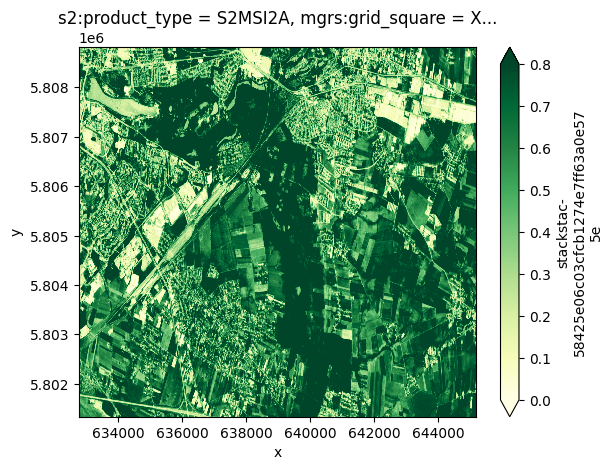

In [85]:
ndvi_comp.plot(vmin=0, vmax=0.8, cmap="YlGn")

And finally, let's compute the NDVI anomaly, i.e., how much does each pixel from the composite deviates from the mean of the whole collection.

In [86]:
anomaly = ndvi_comp - ndvi.mean()

In [ ]:
anomaly = anomaly.compute()

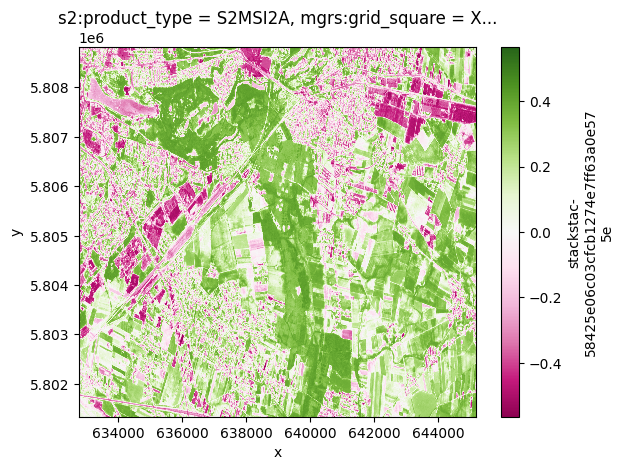

In [88]:
anomaly.plot(cmap="PiYG")

### Downloaing the data

There might be at some point the need to download the scenes that you just queried. To do so you can use the `os` and `urllib` modules that are part of the python standard library as the code snippet below shows. This will download all of the items from your search, so make sure you apply enough filtering so that you don't download data that you don't need.

``` python
download_path = "path/to/dir"

for item in items:
    download_path = os.path.join(item.collection_id, item.id)
    if not os.path.exists(download_path):
        os.makedirs(download_path, exist_ok=True)
    for name, asset in item.assets.items():
        urllib.request.urlretrieve(asset.href, 
                                   os.path.join(download_path, 
                                   os.path.basename(asset.href)))
```